# Electrphoresis os DNA-tethered nanoparticles
Author: ``Sanli Faez (s.faez@uu.nl)``

version: 20/8/2018, 

* Part 1) preprocessing and previewing
* Part 2) extracting timetrace and waveform.
* Part 3) to be completed: finding the average response waveform over all cycles

### Import necessary modules

In [2]:
%pylab inline

import nptdms
import matplotlib.pyplot as plt
import numpy as np
#from tracking_gizmo import LocateParticle


Populating the interactive namespace from numpy and matplotlib


## 1) Read data and preprocess
### 1.1) Choose data file and check measurement attributes

In [3]:
filename = r'/Users/sanli/Repositories/KukuraLab/data/Aug17_DNA/GNP_1Hz/event0.tdms'
tdms_file = nptdms.TdmsFile(filename)
attributes=tdms_file.object("img","cam2").properties
print(attributes)

efr = attributes['Frame Rate']
box = attributes['Pixel Size']


OrderedDict([('Frame Rate', 25.0), ('Exposure Time', 0.0), ('Bin Frame Size', 1.0), ('Pixel Size', 512.0), ('Lost frames during acq', 0.0)])


### 1.2) Put all data from a sequence into an image-cube without any processing

data cube: (2500, 512, 512)
Median, Max, Location: 44.0 4094 (140, 120)


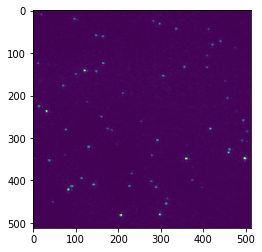

In [4]:
#NOTE: group and channel name depends on labview program. use tdms_file.groups() and tdms_file.group_channels()
data_raw = tdms_file.channel_data('img', 'cam2')
Lx = int(box)   #the frame size should be read from the attrbutes

nf = int(data_raw.size//(Lx*Lx)) #number of recorded frames
frames = data_raw.reshape(nf, Lx, Lx)
print("data cube:", frames.shape)
peakat = np.unravel_index(np.argmax(frames[0], axis=None), frames[0].shape)
print("Median, Max, Location:", np.median(frames[0]), np.amax(frames[0]), peakat)
plt.imshow(frames[0])
plt.show()


### 1.3) pinpoint the movers by looking at the intensity fluctuations at each point

In [6]:
select = 400
mean_img = np.mean(frames[0:select], axis=0)
# dframes = np.copy(frames)
# for i in range(select):
#     dframes[i] = frames[i] - mean_img

var_img = np.std(frames[0:select], axis=0) / mean_img

### 1.4) And/or visually inspect the fluctuations image

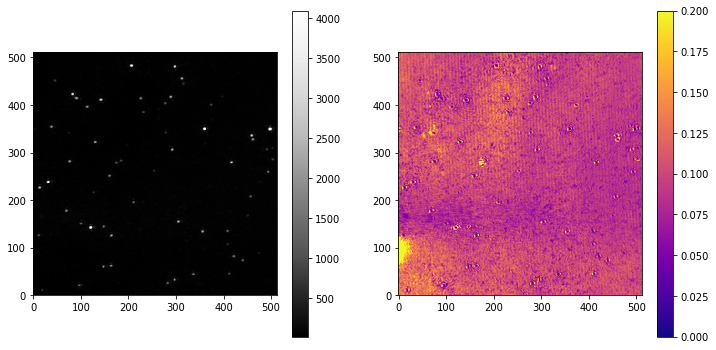

In [7]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
im1 = ax1.imshow(mean_img, cmap='Greys_r', origin ='lower')
plt.colorbar(im1, ax = ax1)

ax2 = plt.subplot(122)
im2 = ax2.imshow(var_img, cmap='plasma', vmin=0, vmax=0.2, origin ='lower')
plt.colorbar(im2, ax = ax2)

plt.show()
 

### 1.3) Define the area of interest around the particle, clean up, and track location

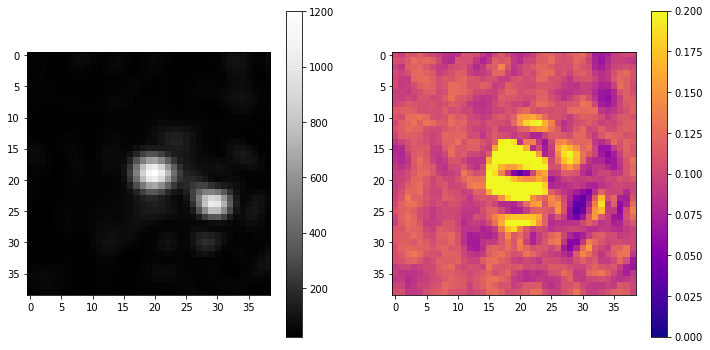

44.3675


In [8]:
iniloc = [278, 175]
extent = 20
sig_floor = np.median(frames[0])

sel = mean_img[iniloc[0]-extent:iniloc[0]+extent-1, iniloc[1]-extent:iniloc[1]+extent-1]
sel_var = var_img[iniloc[0]-extent:iniloc[0]+extent-1, iniloc[1]-extent:iniloc[1]+extent-1]

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
im1 = ax1.imshow(sel, cmap='Greys_r')
plt.colorbar(im1, ax = ax1)

ax2 = plt.subplot(122)
im2 = ax2.imshow(sel_var, cmap='plasma', vmin=0, vmax=0.2)
plt.colorbar(im2, ax = ax2)

plt.show()


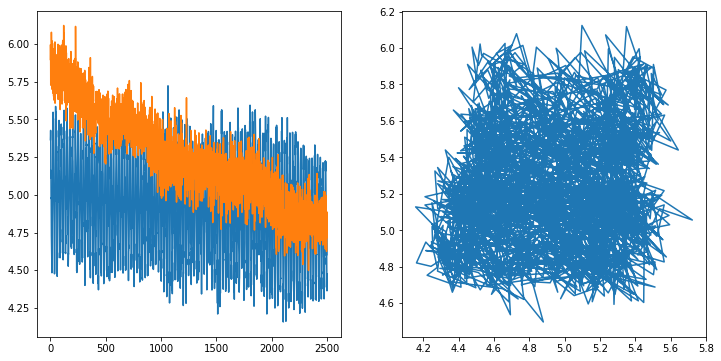

In [9]:
iniloc = [278, 175]
extent = 6


sel = frames[:, iniloc[0]-extent:iniloc[0]+extent-1, iniloc[1]-extent:iniloc[1]+extent-1]

#sig_floor = np.median(mean_img)
# #sel[sel<sig_floor] = 0

def centroid(data):
    h, w = np.shape(data)
    x = np.arange(0, w)
    y = np.arange(0, h)

    X, Y = np.meshgrid(x, y)

    cy = np.sum(X * data) / np.sum(data)
    cx = np.sum(Y * data) / np.sum(data)

    return [cx, cy]

def pointspread(data, cx, cy):
    h, w = np.shape(data)
    x = np.arange(w) - cy
    y = np.arange(h) - cx

    X, Y = np.meshgrid(x, y)
    mass = np.sum(data)
    sy = np.sqrt(np.sum(np.square(X) * data) / mass)
    sx = np.sqrt(np.sum(np.square(Y) * data) / mass)

    return [sx, sy, mass]

track = np.zeros((nf, 5)) #track coordinates: cm_x, cm_y, psf_x, psf_y, mass

for i in range(nf):
    imgpart = sel[i]
    cx, cy = centroid(imgpart)
    sx, sy, mass = pointspread(imgpart, cx, cy)
    track[i, :] = [cx, cy, sx, sy, mass]
    

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax1.plot(track[:,0])
ax1.plot(track[:,1])

ax1 = plt.subplot(122)
ax1.plot(track[:,0],track[:,1])

plt.show()

### 1.4) Get the oscillating components


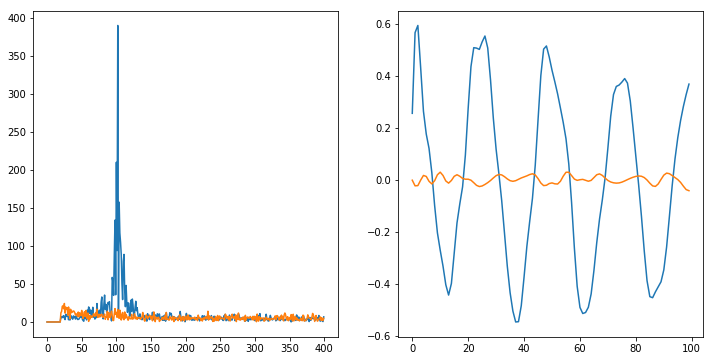

In [13]:
fspec = np.fft.rfft(track, axis=0)
fspec[0:20,:]=0
fspec[500:,:]=0
filtered = np.fft.irfft(fspec, axis = 0)

fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax1.plot(abs(fspec[:400,0]))
ax1.plot(abs(fspec[:400,1]))

ax2 = plt.subplot(122)
ax2.plot(filtered[:100,0])
ax2.plot(filtered[:100,2])
#plt.plot(filtered[:,2])
# 
# dcbase = 25   #fourier index below which counts as drift
# mfreq = dcbase + np.argmax(abs(fspec[dcbase:5*dcbase]))
# print("Fourier component:", mfreq)
# plt.plot(np.arange(mfreq-1,mfreq+2), abs(fspec[mfreq-1:mfreq+2]), '.')
# plt.show()